#### The idea is that we are generalizing Moran processes to allow for squirrels which have fitness that varies in time.

#### We'll compare the fixation probability of SS-squirrels with LL-squirrels. 

#### SS-squirrels (type A) have a low but constant fitness. I'll likely normalize this to 1, but let's see...

#### LL-squirrels (type B) have 0 fitness for a while and then it jumps up above the fitness of type A.

#### Everything needed to build squirrels and get their properties...

In [385]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [346]:
#def squirrel_builder(t, age = 0):
#    return {'type':str(t), 'age':age}

#def get_fitness(squirrel, age_cutoff = 0):
#    t = squirrel['type']
#    age = squirrel['age']
#    if age < age_cutoff:
#        f = pre_cutoff_fitness_dict[t]
#    else:
#        f = post_cutoff_fitness_dict[t]
#    return f


def squirrel_builder(t, beta = 2, age = 0):
    if t == 'A':
        return {'type':'A', 'age':age}
    elif t == 'B':
        return {'type':'B', 'age':age, 'beta':beta}
    else:
        return 'Error!'
    
def get_fitness(squirrel, age_cutoff = 0):
    if squirrel['type'] == 'A':
        return 1
    elif squirrel['type'] == 'B':
        if squirrel['age'] < age_cutoff:
            f = 0
        else:
            f = squirrel['beta']
            
    return f

#### Everything needed for a single birth-death process to occur...

In [347]:
def pick_squirrel_to_give_birth(squirrels, age_cutoff = 0):
    fitnesses = [ get_fitness(squirrel, age_cutoff) for squirrel in squirrels ]
    if fitnesses == [0]*len(squirrels):
        fitnesses = [1]*len(squirrels)
    birth_rv = GeneralDiscreteDistribution(fitnesses)
    birth_squirrel = birth_rv.get_random_element()
    return birth_squirrel

def pick_squirrel_to_die(squirrels):
    N = len(squirrels)
    unif_random = GeneralDiscreteDistribution([1/N for _ in range(N)])
    death_squirrel = unif_random.get_random_element()
    return death_squirrel

def birth_death_process(squirrels, birth_squirrel, death_squirrel):
    new_squirrel = deepcopy(squirrels[birth_squirrel])
    new_squirrel['age'] = -1
    squirrels[death_squirrel] = new_squirrel
    
def increment_ages(squirrels):
    for squirrel in squirrels:
        squirrel['age'] += 1
    
def day_of_squirrels(squirrels, age_cutoff = 0):
    birth_squirrel = pick_squirrel_to_give_birth(squirrels, age_cutoff)
    death_squirrel = pick_squirrel_to_die(squirrels)
    birth_death_process(squirrels, birth_squirrel, death_squirrel)
    increment_ages(squirrels)
    
def many_days_of_squirrels(num_days, squirrels, age_cutoff = 0):
    for t in range(num_days):
        day_of_squirrels(squirrels, age_cutoff)
    return squirrels
    

In [348]:
def of_homogeneous_type(squirrels):
    types = [squirrel['type'] for squirrel in squirrels]
    types = list(set(types))
    num_types = len(types)
    if num_types == 1:
        return True
    else:
        return False
    
def get_homogeneous_type(squirrels):
    if not of_homogeneous_type(squirrels):
        return 'you have a problem'
    else:
        return squirrels[0]['type']

In [349]:
def fixation_process(beta, res_type, mut_type, N, age_cutoff = 0):
    #allow resident squirrels to run for a while
    res_squirrels = [squirrel_builder(res_type, beta)]*N
    many_days_of_squirrels(1000, res_squirrels, age_cutoff)
    
    #introduce a mutant
    increment_ages(res_squirrels)
    squirrels = deepcopy(res_squirrels)
    squirrels[0] = squirrel_builder(mut_type)
    
    #let it run until either fixation or extinction
    while not of_homogeneous_type(squirrels):
        day_of_squirrels(squirrels, age_cutoff)
        
    #get type of winner
    t = get_homogeneous_type(squirrels)
    return t

In [367]:
def fixation_probability(beta, res_type, mut_type, N, age_cutoff = 0, num_runs = 1000):
    winner_dict = {res_type:0, mut_type:0}
    print('Computing fixation probability of a single {} type in a population of {} types'.format(mut_type, res_type))
    for _ in tqdm(range(num_runs)):
        winner = fixation_process(beta, res_type, mut_type, N, age_cutoff)
        winner_dict[winner] += 1
    prob = winner_dict[mut_type]/num_runs.n()
    print('rho_{} = {}'.format(mut_type, prob))
    return prob

In [372]:
def fix_prob_diff(beta, N, age_cutoff = 0, num_runs = 1000):
    #compute fixation probabilties
    rho_A = fixation_probability(beta, 'B', 'A', N, age_cutoff, num_runs)
    rho_B = fixation_probability(beta, 'A','B', N, age_cutoff, num_runs)
    
    #subtract probs and return difference
    return rho_A - rho_B

In [375]:
def find_upper_limit(N, age_cutoff = 0, num_runs = 1000, verbose = False):
    beta = 2
    if verbose:
        print('computing prob difference when beta = 2')
    prob_diff = fix_prob_diff(beta, N, age_cutoff, num_runs)
    if verbose:
        print('fixation prob difference when beta = 2 is {}'.format(prob_diff))
    while prob_diff > 0:
        beta += 1
        if verbose:
            print('checking prob diff when beta = {}'.format(beta))
        prob_diff = fix_prob_diff(beta, N, age_cutoff, num_runs)
        if verbose:
            print('fixation prob difference when beta = {} is {}'.format(beta, prob_diff))
    
    return(beta)
        

In [376]:
find_upper_limit(5, age_cutoff = 2, num_runs = 100, verbose = True)

computing prob difference when beta = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/100 [00:00<?, ?it/s]

rho_A = 0.120000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/100 [00:00<?, ?it/s]

rho_B = 0.170000000000000
fixation prob difference when beta = 2 is -0.0500000000000000


2

#### There is a slight issue. With a small N and a large delay to the LL fitness, squirrels v likely die before they get enough of a foothold in society to take over. This can be fixed by picking a large N. 

In [377]:
def get_fix_diff_zero(N, age_cutoff = 0, num_runs = 1000, verbose = False):
    if verbose:
        print('Looking for the beta value for which rho_A = rho_B')
        print('Parameters N = {}, delay to LL reward = {}'.format(N, age_cutoff))  
        
    b = find_upper_limit(N, age_cutoff, num_runs, verbose)
    if verbose:
        print('proceed to find zero on interval [{}, {}]'.format(b - 1, b))
        
    def f(beta):
        return fix_prob_diff(beta, N, age_cutoff, num_runs)
    
    beta_equal_fitness = QuadraticInterpolate(f, b-1, b)
    return beta_equal_fitness

In [380]:
get_fix_diff_zero(5, 2, 1000, True)

Looking for the beta value for which rho_A = rho_B
Parameters N = 5, delay to LL reward = 2
computing prob difference when beta = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.103000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.182000000000000
fixation prob difference when beta = 2 is -0.0790000000000000
proceed to find zero on interval [1, 2]
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.364000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.204000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.204000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.218000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.110000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.205000000000000


1.44713642256610

In [381]:
results = []

for i in range(5):
    print('doing round {}'.format(i))
    r = get_fix_diff_zero(5, 2, 1000, True)
    results.append(r)

doing round 0
Looking for the beta value for which rho_A = rho_B
Parameters N = 5, delay to LL reward = 2
computing prob difference when beta = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.118000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.218000000000000
fixation prob difference when beta = 2 is -0.100000000000000
proceed to find zero on interval [1, 2]
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.341000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.192000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.204000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.206000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0990000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.176000000000000
doing round 1
Looking for the beta value for which rho_A = rho_B
Parameters N = 5, delay to LL reward = 2
computing prob difference when beta = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.124000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.207000000000000
fixation prob difference when beta = 2 is -0.0830000000000000
proceed to find zero on interval [1, 2]
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.382000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.217000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.186000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.198000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.115000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.207000000000000
doing round 2
Looking for the beta value for which rho_A = rho_B
Parameters N = 5, delay to LL reward = 2
computing prob difference when beta = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.101000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.203000000000000
fixation prob difference when beta = 2 is -0.102000000000000
proceed to find zero on interval [1, 2]
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.379000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.210000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.206000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.205000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.205000000000000
doing round 3
Looking for the beta value for which rho_A = rho_B
Parameters N = 5, delay to LL reward = 2
computing prob difference when beta = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.120000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.182000000000000
fixation prob difference when beta = 2 is -0.0620000000000000
proceed to find zero on interval [1, 2]
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.373000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.187000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.199000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.217000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.119000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.216000000000000
doing round 4
Looking for the beta value for which rho_A = rho_B
Parameters N = 5, delay to LL reward = 2
computing prob difference when beta = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.119000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.210000000000000
fixation prob difference when beta = 2 is -0.0910000000000000
proceed to find zero on interval [1, 2]
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.391000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.183000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.245000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.220000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.117000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.194000000000000


In [382]:
results

[1.49120249647075,
 1.45484644237597,
 1.50365568298629,
 1.43961673074706,
 1.59259259259259]

In [383]:
results = []

for t in tqdm(range(10)):
    print('computing required for indifference at delay = {}'.format(t))
    r = get_fix_diff_zero(20, t, 1000, False)
    print('beta_indifferent = {}'.format(r))
    results.append(r)

  0%|          | 0/10 [00:00<?, ?it/s]

computing required for indifference at delay = 0
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.480000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0490000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.480000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.494000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.482000000000000
beta_indifferent = None
computing required for indifference at delay = 1
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.433000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0690000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.468000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.459000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.461000000000000
beta_indifferent = None
computing required for indifference at delay = 2
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.359000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.107000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.456000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00200000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.389000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.410000000000000
beta_indifferent = None
computing required for indifference at delay = 3
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.350000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.147000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.346000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.328000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.367000000000000
beta_indifferent = None
computing required for indifference at delay = 4
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.324000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.176000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.300000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00800000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.314000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.321000000000000
beta_indifferent = None
computing required for indifference at delay = 5
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.289000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.208000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.295000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00900000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.267000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.256000000000000
beta_indifferent = None
computing required for indifference at delay = 6
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.229000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.279000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.235000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0120000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.237000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.218000000000000
beta_indifferent = 1.05619555677107
computing required for indifference at delay = 7
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00200000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.198000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.317000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.204000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0300000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.190000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.201000000000000
beta_indifferent = 1.16045992661164
computing required for indifference at delay = 8
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.147000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.320000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.156000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0550000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.173000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00200000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.162000000000000
beta_indifferent = 1.23771705314895
computing required for indifference at delay = 9
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00500000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.120000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.364000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.135000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0740000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.137000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00200000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.117000000000000
beta_indifferent = 1.34877197512632


In [388]:
for t in tqdm(range(10, 20)):
    print('computing required for indifference at delay = {}'.format(t))
    r = get_fix_diff_zero(20, t, 1000, False)
    print('beta_indifferent = {}'.format(r))
    results.append(r)

  0%|          | 0/10 [00:00<?, ?it/s]

computing required for indifference at delay = 10
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00900000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.109000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.377000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0980000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.117000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.103000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00600000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.110000000000000
beta_indifferent = 1.53764113687870
computing required for indifference at delay = 11
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0160000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0750000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.399000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0730000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.135000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0760000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0130000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0660000000000000
beta_indifferent = 1.68309261376428
computing required for indifference at delay = 12
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0240000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0480000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.451000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0460000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.167000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0540000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0250000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0500000000000000
beta_indifferent = 1.85107441953461
computing required for indifference at delay = 13
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0290000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0200000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0330000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0470000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0420000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0300000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0300000000000000
beta_indifferent = 2.04923511177326
computing required for indifference at delay = 14
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0580000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0160000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0220000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0520000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0230000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00600000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0200000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0230000000000000
beta_indifferent = 2.28899291171082
computing required for indifference at delay = 15
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.109000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0150000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00200000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0200000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0750000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00900000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00600000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0120000000000000
beta_indifferent = 2.55574109851994
computing required for indifference at delay = 16
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.144000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00600000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00500000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.124000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.0100000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0190000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00400000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00300000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00500000000000000
beta_indifferent = 2.67032565392228
computing required for indifference at delay = 17
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.158000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00500000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00300000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.160000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00400000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0310000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00400000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00400000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00200000000000000
beta_indifferent = None
computing required for indifference at delay = 18
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.180000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.000000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00100000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00200000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0110000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00100000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00300000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00400000000000000
beta_indifferent = 3.37830094339717
computing required for indifference at delay = 19
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.224000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00100000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0200000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00200000000000000
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00200000000000000
Computing left endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.0190000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.000000000000000
Computing midpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.000000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.00100000000000000
Computing right endpoint
Computing fixation probability of a single A type in a population of B types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_A = 0.00100000000000000
Computing fixation probability of a single B type in a population of A types


  0%|          | 0/1000 [00:00<?, ?it/s]

rho_B = 0.000000000000000
beta_indifferent = None


In [384]:
results

[None,
 None,
 None,
 None,
 None,
 None,
 1.05619555677107,
 1.16045992661164,
 1.23771705314895,
 1.34877197512632]

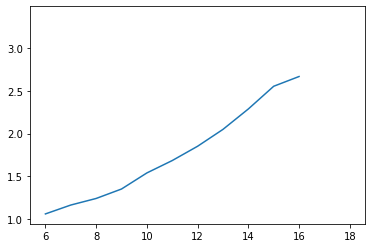

In [389]:
plt.plot(results)
plt.show()

In [310]:
def QuadraticInterpolate(f, t0, t1):
    # Find the midpoint between t0 and t1:
    t2 = (t0 + t1) / 2

    # Evaluate the function at all three points.
    print('Computing left endpoint')
    f0 = f(t0)
    
    print('Computing midpoint')
    f2 = f(t2)
    
    print('Computing right endpoint')
    f1 = f(t1)

    # Compute the coefficients of the parabola p(x) that passes
    # through the three points (t0,f0), (t2,f2), (t1,f1).
    Q = (f1 + f0)/2 - f2
    R = (f1 - f0)/2
    S = f2

    if Q == 0:
        # Special case: the three points are collinear.
        if R == 0:
            # There is no root because the line is horizontal.
            return None
        # Solve for the place where the line passes through the x-axis.
        x = -S/R
        # Is the root within the search interval?
        if -1 <= x <= +1:
            # Convert x back to the original independent variable t:
            t = (t2 - t0)*x + t2
            return t
        # The x value was outside the search interval.
        # Therefore it is not valid.
        return None

    # The approximation curve is a parabola.
    # Calculate the radicand u. Then we can determine
    # how many real roots there are.
    u = R*R - 4*Q*S

    # We require a non-tangent real root.
    if u <= 0:
        # There are no real roots for the parabolic curve,
        # or there is a single tangent root.
        return None

    ru = sqrt(u)
    x1 = (-R + ru) / (2*Q)
    x2 = (-R - ru) / (2*Q)

    # Form a list of the x values that are within
    # the normalized interval [-1, +1].
    xlist = [x for x in [x1, x2] if -1 <= x <= +1]

    # There must be exactly one real root inside
    # the normalized interval in order for the
    # solution to be considered valid.
    if len(xlist) == 1:
        # Translate the normalized parameter x back
        # into the independent variable t:
        t = (t2 - t0)*xlist[0] + t2
        return t

    # Either there were no valid roots, or
    # there were 2 roots (interval was too large).
    return None